In [38]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
FINE_TUNNING = True

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [42]:
# import tensorflow as tf

# # Get the GPU device name.
# device_name = tf.test.gpu_device_name()

# # The device name should look like the following:
# if device_name == '/device:GPU:0':
#     print('Found GPU at: {}'.format(device_name))
# else:
#     raise SystemError('GPU device not found')

In [43]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/drive/MyDrive/TCC/csvs/pre_normalized.csv")

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

df["label"] = df["label"].replace({"true": 1, "fake": 0})

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 7,200



,text,label
3098,globo entra vivo reporter foge manifestantes s...,0
2531,muro trump sai papel comeca tornar realidade v...,0
4071,giba diz emprestou dinheiro amigos pagar r 90 ...,1
1287,william waack subestimei capacidade dilma apro...,0
2540,jornalista folha/sp extrapola entrevistar gent...,0
263,vamos estuprar corruptos afirmam presos papuda...,0
6123,durmo acordo pensando nele diz mae menino sumi...,1
2439,morre 78 anos ator humorista paulo silvino fal...,0
3749,tribunal federal nega dois habeas corpus defes...,1
1199,edir macedo podera disputar eleicoes presidenc...,0


In [44]:
# Get the lists of sentences and their labels.
sentences = df.text.values
labels = df.label.values

In [45]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=True)

Loading BERT tokenizer...


In [46]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  autor bestseller cita 5 expressoes indicam inteligencia emocional lista publicada site linkedin travis bradberry autor bestseller inteligencia emocional 20 inteligencia emocional conceito presente psicologia criado psicologo norteamericano daniel goleman pessoa inteligencia emocional possui aptidao lidar emocoes goleman subdivide inteligencia emocional 5 habilidades autoconhecimento emocional controle emocional automotivacao empatia desenvolvimento relacionamentos interpessoais voltando livro inteligencia emocional 20 autor diz vivemos atualmente mundo pessoas parecem ouvir esperam vez falar cada vez voltam foco si propria egocentrismo perdendo capacidade enxergar outro bradberry sugere algumas expressoes podem atrapalhar relacionamentos especial relacionamentos profissionais 1 sempre nunca ambas expressoes impedem conversa equilibrada deixa outro defensiva autor diz apontar dedo outro sempre incomoda ex sempre faz nunca faz coisa certa indica 2 sempre digo travis destaca e

In [47]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  1844


In [48]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  autor bestseller cita 5 expressoes indicam inteligencia emocional lista publicada site linkedin travis bradberry autor bestseller inteligencia emocional 20 inteligencia emocional conceito presente psicologia criado psicologo norteamericano daniel goleman pessoa inteligencia emocional possui aptidao lidar emocoes goleman subdivide inteligencia emocional 5 habilidades autoconhecimento emocional controle emocional automotivacao empatia desenvolvimento relacionamentos interpessoais voltando livro inteligencia emocional 20 autor diz vivemos atualmente mundo pessoas parecem ouvir esperam vez falar cada vez voltam foco si propria egocentrismo perdendo capacidade enxergar outro bradberry sugere algumas expressoes podem atrapalhar relacionamentos especial relacionamentos profissionais 1 sempre nunca ambas expressoes impedem conversa equilibrada deixa outro defensiva autor diz apontar dedo outro sempre incomoda ex sempre faz nunca faz coisa certa indica 2 sempre digo travis destaca ex

In [49]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.80 * len(dataset))
val_size = (len(dataset) - train_size)//2
test_size = (len(dataset) - train_size - val_size)

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

5,760 training samples
  720 validation samples
  720 test samples


In [50]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [51]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [52]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (29794, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [53]:
for param in model.base_model.parameters():
    param.requires_grad = FINE_TUNNING

In [54]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [55]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

#print(pred_probs)
name = "com ajusto fino - " + str(epochs) + " epochs"
csv_name = "com_ajusto_fino_" + str(epochs) + "_epochs"


# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [56]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [57]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [58]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    360.    Elapsed: 0:01:00.
  Batch    80  of    360.    Elapsed: 0:01:59.
  Batch   120  of    360.    Elapsed: 0:02:58.
  Batch   160  of    360.    Elapsed: 0:03:58.
  Batch   200  of    360.    Elapsed: 0:04:57.
  Batch   240  of    360.    Elapsed: 0:05:56.
  Batch   280  of    360.    Elapsed: 0:06:55.
  Batch   320  of    360.    Elapsed: 0:07:54.

  Average training loss: 0.32
  Training epcoh took: 0:08:54

Running Validation...
  Accuracy: 0.95
  Validation Loss: 0.14
  Validation took: 0:00:25

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    360.    Elapsed: 0:00:59.
  Batch    80  of    360.    Elapsed: 0:01:58.
  Batch   120  of    360.    Elapsed: 0:02:57.
  Batch   160  of    360.    Elapsed: 0:03:57.
  Batch   200  of    360.    Elapsed: 0:04:56.
  Batch   240  of    360.    Elapsed: 0:05:55.
  Batch   280  of    360.    Elapsed: 0:06:54.
  Batch   320  of    360.    Elapsed: 0:07:54.

  Averag

In [59]:
import pandas as pd

# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

df_stats.to_csv("/content/drive/MyDrive/TCC/results/csvs/" + csv_name + "_stats.csv")

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.316528,0.137625,0.948611,0:08:54,0:00:25
2,0.103476,0.169390,0.954167,0:08:53,0:00:25
3,0.037169,0.192301,0.955556,0:08:52,0:00:25


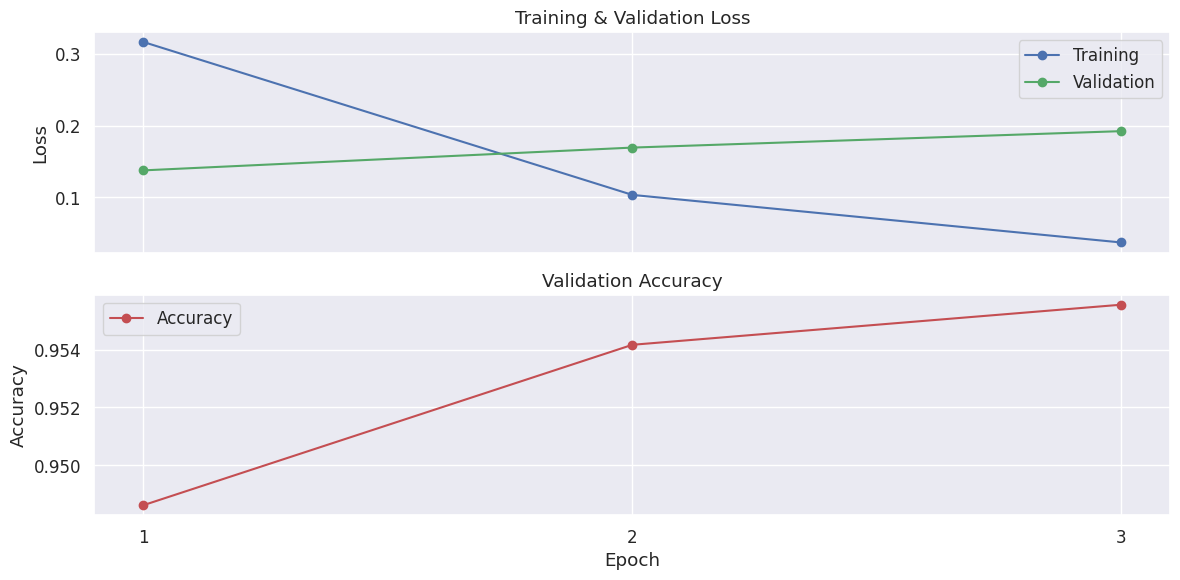

In [60]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.1)
fig, ax = plt.subplots(2,1 ,figsize=(12,6), sharex=True)
ax = ax.flatten()

# Plot the learning curve.
ax[0].plot(df_stats['Training Loss'], 'b-o', label="Training")
ax[0].plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

ax[1].plot(df_stats['Valid. Accur.'], 'r-o', label="Accuracy")



# # Label the plot.
ax[0].set_title("Training & Validation Loss")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].set_title("Validation Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].set_xticks(range(1, epochs+1))

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/TCC/results/images/"+csv_name+"_training.png")

plt.show()

In [61]:
import pandas as pd

df_covid = pd.read_csv("/content/drive/MyDrive/TCC/csvs/covid.csv")
df_custom = pd.read_csv("/content/drive/MyDrive/TCC/csvs/news_validation.csv")

df_covid["label"] = df_covid["label"].replace({"true": 1, "fake": 0})
df_custom["label"] = df_custom["label"].replace({"true": 1, "fake": 0})

In [62]:
def get_prediction_dataloader(df):
    # Create sentence and label lists
    sentences = df.text.values
    labels = df.label.values

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 512,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )
        
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    # Set the batch size.  
    batch_size = 16  

    # Create the DataLoader.
    prediction_data = TensorDataset(input_ids, attention_masks, labels)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size) 

    return prediction_dataloader


In [63]:
prediction_data_test = test_dataset
prediction_sampler_test = SequentialSampler(prediction_data_test)
prediction_dataloader_test = DataLoader(prediction_data_test, sampler=prediction_sampler_test, batch_size=batch_size)

prediction_dataloader_covid = get_prediction_dataloader(df_covid)
prediction_dataloader_custom = get_prediction_dataloader(df_custom)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [64]:
def predict_sentences(prediction_dataloader):  

  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []

  # Predict 
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
    
  return predictions, true_labels

In [65]:
def show_mcc_per_batch(predictions, true_labels):

  from sklearn.metrics import matthews_corrcoef

  matthews_set = []

  # For each input batch...
  for i in range(len(true_labels)):
    
    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    
    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

  # Create a barplot showing the MCC score for each batch of test samples.
  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, errorbar=None)

  ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

  plt.title('MCC Score per Batch')
  plt.ylabel('MCC Score (-1 to +1)')
  plt.xlabel('Batch #')

  #set y_axis limit
  ##plt.ylim(-1, 1)

  plt.savefig("/content/drive/MyDrive/TCC/results/images/"+csv_name+"_mcc.png")

  plt.show()

In [66]:
def get_mean_mcc(predictions, true_labels):
    from sklearn.metrics import matthews_corrcoef

    # Combine the results across all batches. 
    flat_predictions = np.concatenate(predictions, axis=0)

    # For each sample, pick the label (0 or 1) with the higher score.
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

    # Combine the correct labels for each batch into a single list.
    flat_true_labels = np.concatenate(true_labels, axis=0)

    # Calculate the MCC
    mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

    print('Total MCC: %.3f' % mcc)

In [67]:
def generate_measures_csv(true_flat, pred_flat, pred_probs, mode):

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import matthews_corrcoef

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(true_flat, pred_flat)
    print('Accuracy: %f' % accuracy)

    # precision tp / (tp + fp)
    precision = precision_score(true_flat, pred_flat, pos_label=0)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(true_flat, pred_flat, pos_label=0)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(true_flat, pred_flat, pos_label=0)
    print('F1 score: %f' % f1)

    # matthews: tp / (tp + fp)
    matthews = matthews_corrcoef(true_flat, pred_flat)
    print('Matthews Correlation Coefficient: %f' % matthews)

    
    import numpy as np
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import roc_curve

    logits = torch.from_numpy(pred_probs)
    probs = torch.softmax(logits, dim=1)
    pos_probs = probs[:, 1]
    pos_probs_np = pos_probs.detach().cpu().numpy()

    auc = roc_auc_score(true_flat, pos_probs_np)
    print('AUC: %.3f' % auc)

    fpr, tpr, _ = roc_curve(true_flat, pos_probs_np)

    r_probs = [0 for _ in range(len(true_flat))]
    r_fpr, r_tpr, _ = roc_curve(true_flat, r_probs)
    r_auc = roc_auc_score(true_flat, r_probs)

    plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
    plt.plot(fpr, tpr, marker='.', label='Bert Model (AUROC = %0.3f)' % auc)    

    # Title
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    plt.savefig("/content/drive/MyDrive/TCC/results/images/"+csv_name+"_roc_"+mode+".png")
    # Show plot
    plt.show()

    from sklearn.metrics import average_precision_score

    auprc = average_precision_score(true_flat, pos_probs_np)
    print('AUPRC: %.3f' % auprc)


    #Generate dataframe

    df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1', 'MCC', 'AUC', 'AUPRC'])
    df.loc[name] = [accuracy, precision, recall, f1, matthews, auc, auprc]

    df.to_csv("/content/drive/MyDrive/TCC/results/csvs/" + csv_name + "_measures_" + mode + ".csv")



In [68]:
def generate_classfication_report(predictions, true_labels, mode, csv = False):

    from sklearn.metrics import classification_report

    #print(predictions)
    #convert true_labels to single list
    true_flat = [item for sublist in true_labels for item in sublist]

    pred_probs = np.concatenate(predictions, axis=0)
    pred_flat = [np.argmax(item) for sublist in predictions for item in sublist]

    if csv:
        generate_measures_csv(true_flat, pred_flat, pred_probs, mode)

    report = classification_report(true_flat, pred_flat, zero_division=1, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.round(2)

    report_df.to_csv("/content/drive/MyDrive/TCC/results/csvs/" + csv_name + "_report_" + mode +".csv")


    return report_df

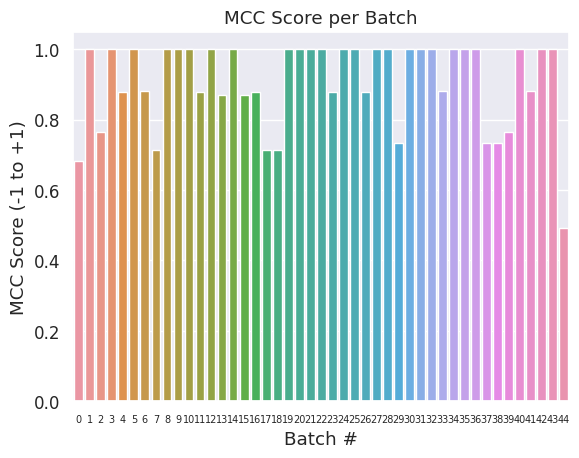

Total MCC: 0.908


Accuracy: 0.954167
Precision: 0.959654
Recall: 0.946023
F1 score: 0.952790
Matthews Correlation Coefficient: 0.908347
AUC: 0.992


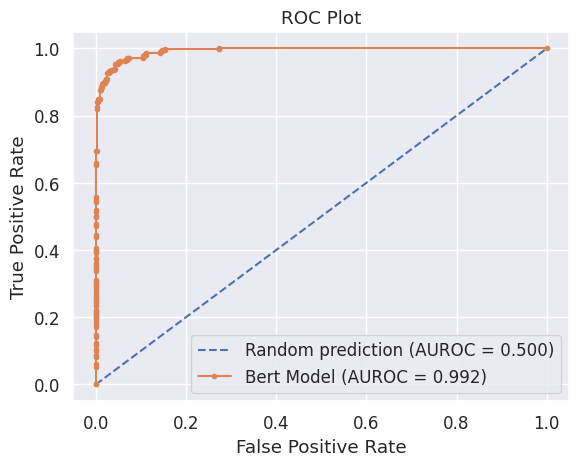

AUPRC: 0.993


,precision,recall,f1-score,support
0,0.96,0.95,0.95,352.00
1,0.95,0.96,0.96,368.00
accuracy,0.95,0.95,0.95,0.95
macro avg,0.95,0.95,0.95,720.00
weighted avg,0.95,0.95,0.95,720.00


In [69]:
predictions_test, true_labels_test = predict_sentences(prediction_dataloader_test)

show_mcc_per_batch(predictions_test, true_labels_test)
get_mean_mcc(predictions_test, true_labels_test)
print("\n")
generate_classfication_report(predictions_test, true_labels_test, mode = "test",csv = True)

Total MCC: 0.605


Accuracy: 0.800000
Precision: 0.846154
Recall: 0.733333
F1 score: 0.785714
Matthews Correlation Coefficient: 0.605406
AUC: 0.822


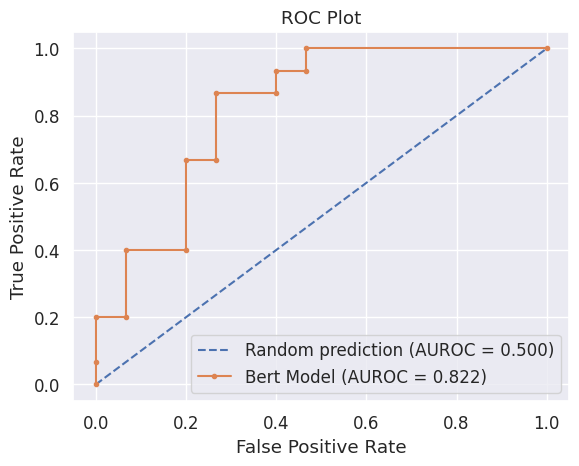

AUPRC: 0.804


,precision,recall,f1-score,support
0,0.85,0.73,0.79,15.0
1,0.76,0.87,0.81,15.0
accuracy,0.80,0.80,0.80,0.8
macro avg,0.81,0.80,0.80,30.0
weighted avg,0.81,0.80,0.80,30.0


In [70]:
predictions_covid, true_labels_covid = predict_sentences(prediction_dataloader_covid)

get_mean_mcc(predictions_covid, true_labels_covid)
print("\n")
generate_classfication_report(predictions_covid, true_labels_covid, mode = "covid",csv = True)

Total MCC: 0.745


Accuracy: 0.857143
Precision: 1.000000
Recall: 0.714286
F1 score: 0.833333
Matthews Correlation Coefficient: 0.745356
AUC: 0.878


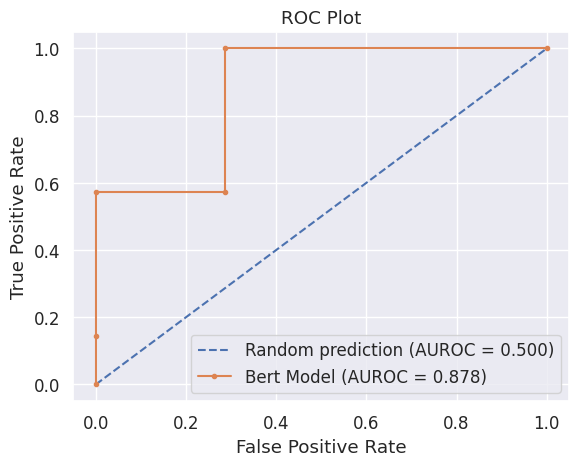

AUPRC: 0.892


,precision,recall,f1-score,support
0,1.00,0.71,0.83,7.00
1,0.78,1.00,0.88,7.00
accuracy,0.86,0.86,0.86,0.86
macro avg,0.89,0.86,0.85,14.00
weighted avg,0.89,0.86,0.85,14.00


In [71]:
predictions_custom, true_labels_custom = predict_sentences(prediction_dataloader_custom)

get_mean_mcc(predictions_custom, true_labels_custom)
print("\n")
generate_classfication_report(predictions_custom, true_labels_custom, mode = "custom",csv = True)